In [1]:
#is there a difference between duplicate samples and singletons in sample qc metrics?
import hail as hl
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels import robust
import numpy as np

hl.plot.output_notebook()

sc = pyspark.SparkContext()
tmp_dir = "hdfs://spark-master:9820/"
lustre_dir = "file:///lustre/scratch123/qc/"
plot_dir = "/lustre/scratch123/qc/plots/"

hl.init(sc=sc, tmp_dir=tmp_dir, default_reference="GRCh38")

Loading BokehJS ...

2022-05-04 12:01:22 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/backend/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/backend/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2
SparkUI available at http://spark-master:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.88-7d39379870da
LOGGING: writing to /home/ubuntu/jupyter/hail-20220504-1201-0.2.88-7d39379870da.log


In [2]:
#starting point is the sample QC on variants filtered by stringent VAF, DP and QC filters
sample_qc_htfile = lustre_dir + "/matrixtables/mt_pops_sampleqc.ht"
ht = hl.read_table(sample_qc_htfile)
ht.show()

+-------------------+---------+---------------------+--------------+
| s                 | batch   | sequencing_location | assigned_pop |
+-------------------+---------+---------------------+--------------+
| str               | str     | str                 | str          |
+-------------------+---------+---------------------+--------------+
| "EGAN00003143328" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143329" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143330" | "38268" | "Sanger"            | "AFR"        |
| "EGAN00003143331" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143334" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143336" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143337" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143338" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143339" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143340" | "38268" | "Sanger"            | "EUR"        |
+-------------------+---------+---------------------+--------------+

+-------------------------+--------------------------+------------------------+
| sample_qc.dp_stats.mean | sample_qc.dp_stats.stdev | sample_qc.dp_stats.min |
+-------------------------+--------------------------+------------------------+
|                 float64 |                  float64 |                float64 |
+-------------------------+--------------------------+------------------------+
|                3.59e+01 |                 1.38e+01 |               2.10e+01 |
|                3.50e+01 |                 1.12e+01 |               2.10e+01 |
|                3.54e+01 |                 1.16e+01 |               2.10e+01 |
|                3.56e+01 |                 1.27e+01 |               2.10e+01 |
|                3.51e+01 |                 1.08e+01 |               2.10e+01 |
|                3.55e+01 |                 1.24e+01 |               2.10e+01 |
|                3.62e+01 |                 1.49e+01 |               2.10e+01 |
|                3.51e+01 |                 1.19e+01 |               2.10e+01 |
|                3.56e+01 |                 1.23e+01 |               2.10e+01 |
|                3.54e+01 |                 1.20e+01 |               2.10e+01 |
+-------------------------+--------------------------+------------------------+

+------------------------+-------------------------+--------------------------+
| sample_qc.dp_stats.max | sample_qc.gq_stats.mean | sample_qc.gq_stats.stdev |
+------------------------+-------------------------+--------------------------+
|                float64 |                 float64 |                  float64 |
+------------------------+-------------------------+--------------------------+
|               1.32e+03 |                8.52e+01 |                 1.56e+01 |
|               1.04e+03 |                8.40e+01 |                 1.62e+01 |
|               1.30e+03 |                8.44e+01 |                 1.61e+01 |
|               1.01e+03 |                8.48e+01 |                 1.59e+01 |
|               1.01e+03 |                8.41e+01 |                 1.62e+01 |
|               1.00e+03 |                8.45e+01 |                 1.60e+01 |
|               1.53e+03 |                8.54e+01 |                 1.55e+01 |
|               1.10e+03 |                8.41e+01 |                 1.61e+01 |
|               1.17e+03 |                8.47e+01 |                 1.58e+01 |
|               1.16e+03 |                8.46e+01 |                 1.59e+01 |
+------------------------+-------------------------+--------------------------+

+------------------------+------------------------+---------------------+
| sample_qc.gq_stats.min | sample_qc.gq_stats.max | sample_qc.call_rate |
+------------------------+------------------------+---------------------+
|                float64 |                float64 |             float64 |
+------------------------+-----------

In [3]:
#filter to sanger only to remove Broad samples as these differ in numbers of indels and may skew the result
ht = ht.filter(ht.sequencing_location == 'Sanger')

In [4]:
#create ht containing only confident duplicates, there is no header so the column is called f0
duplicate_sample_list = lustre_dir + "/resources/sanger_samples_in_confident_dups.txt"
duplicate_samples = hl.import_table(duplicate_sample_list, no_header=True).key_by('f0')
duplicate_samples.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'f0': str 
----------------------------------------
Key: ['f0']
----------------------------------------


2022-05-04 12:01:36 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)


In [5]:
duplicate_ht = ht.filter(hl.is_defined(duplicate_samples[ht.s]))
duplicate_ht.show()

2022-05-04 12:01:38 Hail: INFO: Ordering unsorted dataset with network shuffle  


+-------------------+---------+---------------------+--------------+
| s                 | batch   | sequencing_location | assigned_pop |
+-------------------+---------+---------------------+--------------+
| str               | str     | str                 | str          |
+-------------------+---------+---------------------+--------------+
| "EGAN00003143336" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143339" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143342" | "38504" | "Sanger"            | "EUR"        |
| "EGAN00003143343" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143345" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143351" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143359" | "38504" | "Sanger"            | "EUR"        |
| "EGAN00003143360" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143361" | "38504" | "Sanger"            | "EUR"        |
| "EGAN00003143363" | "38504" | "Sanger"            | "EUR"        |
+-------------------+---------+---------------------+--------------+

+-------------------------+--------------------------+------------------------+
| sample_qc.dp_stats.mean | sample_qc.dp_stats.stdev | sample_qc.dp_stats.min |
+-------------------------+--------------------------+------------------------+
|                 float64 |                  float64 |                float64 |
+-------------------------+--------------------------+------------------------+
|                3.55e+01 |                 1.24e+01 |               2.10e+01 |
|                3.56e+01 |                 1.23e+01 |               2.10e+01 |
|                3.35e+01 |                 1.11e+01 |               2.10e+01 |
|                3.51e+01 |                 1.18e+01 |               2.10e+01 |
|                3.58e+01 |                 1.27e+01 |               2.10e+01 |
|                3.56e+01 |                 1.22e+01 |               2.10e+01 |
|                3.29e+01 |                 9.85e+00 |               2.10e+01 |
|                3.56e+01 |                 1.31e+01 |               2.10e+01 |
|                3.36e+01 |                 1.17e+01 |               2.10e+01 |
|                3.31e+01 |                 1.02e+01 |               2.10e+01 |
+-------------------------+--------------------------+------------------------+

+------------------------+-------------------------+--------------------------+
| sample_qc.dp_stats.max | sample_qc.gq_stats.mean | sample_qc.gq_stats.stdev |
+------------------------+-------------------------+--------------------------+
|                float64 |                 float64 |                  float64 |
+------------------------+-------------------------+--------------------------+
|               1.00e+03 |                8.45e+01 |                 1.60e+01 |
|               1.17e+03 |                8.47e+01 |                 1.58e+01 |
|               1.16e+03 |                8.50e+01 |                 1.38e+01 |
|               1.11e+03 |                8.39e+01 |                 1.63e+01 |
|               1.08e+03 |                8.50e+01 |                 1.57e+01 |
|               1.14e+03 |                8.48e+01 |                 1.58e+01 |
|               8.81e+02 |                8.40e+01 |                 1.43e+01 |
|               1.34e+03 |                8.47e+01 |                 1.58e+01 |
|               1.19e+03 |                8.51e+01 |                 1.37e+01 |
|               1.03e+03 |                8.44e+01 |                 1.41e+01 |
+------------------------+-------------------------+--------------------------+

+------------------------+------------------------+---------------------+
| sample_qc.gq_stats.min | sample_qc.gq_stats.max | sample_qc.call_rate |
+------------------------+------------------------+---------------------+
|                float64 |                float64 |             float64 |
+------------------------+-----------

In [6]:
duplicate_ht.count()#count to check the expected number of samples is left

2022-05-04 12:02:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2593

In [7]:
#create ht containing only potential duplicates, there is no header so the column is called f0
poss_duplicate_sample_list = lustre_dir + "/resources/samples_in_potential_dups.txt"
poss_duplicate_samples = hl.import_table(poss_duplicate_sample_list, no_header=True).key_by('f0')
singleton_ht = ht.filter(hl.is_defined(poss_duplicate_samples[ht.s]), keep = False)
singleton_ht.count()

2022-05-04 12:02:24 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)
2022-05-04 12:02:26 Hail: INFO: Ordering unsorted dataset with network shuffle1]


9238

In [8]:
#convert to pandas dfs, and drop NA values as these mess up plots
duplicate_df = duplicate_ht.to_pandas(flatten=True).dropna()
singleton_df = singleton_ht.to_pandas(flatten=True).dropna()

duplicate_df.head()

2022-05-04 12:02:31 Hail: INFO: Ordering unsorted dataset with network shuffle6]
2022-05-04 12:02:36 Hail: INFO: Ordering unsorted dataset with network shuffle  


,s,batch,sequencing_location,assigned_pop,sample_qc.dp_stats.mean,sample_qc.dp_stats.stdev,sample_qc.dp_stats.min,sample_qc.dp_stats.max,sample_qc.gq_stats.mean,sample_qc.gq_stats.stdev,...,sample_qc.n_snp,sample_qc.n_insertion,sample_qc.n_deletion,sample_qc.n_transition,sample_qc.n_transversion,sample_qc.n_star,sample_qc.r_ti_tv,sample_qc.r_het_hom_var,sample_qc.r_insertion_deletion,sample_qc.heterozygosity_rate
0,EGAN00003143336,38268,Sanger,EUR,35.471881,12.422262,21.0,1001.0,84.473757,16.034462,...,61085,1917,2198,43859,17226,2395,2.546093,1.712116,0.872157,0.006219
1,EGAN00003143339,38268,Sanger,EUR,35.560942,12.253054,21.0,1171.0,84.738734,15.849736,...,62183,1967,2292,44701,17482,2617,2.556973,1.746250,0.858202,0.006230
2,EGAN00003143342,38504,Sanger,EUR,33.467457,11.067321,21.0,1155.0,84.990181,13.833554,...,59309,1750,2005,42601,16708,2078,2.549737,1.782121,0.872818,0.006505
3,EGAN00003143343,38268,Sanger,EUR,35.127457,11.779046,21.0,1108.0,83.881132,16.280944,...,61617,1910,2274,44338,17279,2270,2.566005,1.723815,0.839930,0.006197
4,EGAN00003143345,38268,Sanger,EUR,35.824171,12.696587,21.0,1080.0,85.012552,15.738894,...,63868,2116,2508,45670,18198,2781,2.509616,1.751688,0.843700,0.006203


In [9]:
#violin plots
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample type')
    
def violin_plot(metric, label):
    
    m1 = duplicate_df[metric].median()
    m2 = singleton_df[metric].median()
    mad1 = robust.mad(duplicate_df[metric])
    mad2 = robust.mad(singleton_df[metric])
    meds = np.array([m1, m2])
    q1 = np.array([m1-(4*mad1), m2-(4*mad2)])
    q2 = np.array([m1+(4*mad1), m2+(4*mad2)])

    fig, ax = plt.subplots()
    plottitle = label + " split by duplicate and singleton samples: \nMedians and +/-4xMAD shown"
    ax.set_title(plottitle)
    ax.set_ylabel(label)

    violin_parts = ax.violinplot([duplicate_df[metric], singleton_df[metric]], showmeans=False, showmedians=False, showextrema=False)

    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('black')
    
    inds = np.arange(1, len(meds) + 1)
    ax.scatter(inds, meds, marker='o', color='black', s=30, zorder=3)
    ax.vlines(inds, q1, q2, color='k', linestyle='-', lw=2)
    labels = ['Duplicates', 'Singletons']
    set_axis_style(ax, labels)
    
    metric = metric.replace('.', '_')
    plotfile = plot_dir + '/sample_qc/' + metric + '_dup_vs_singleton.png'
    plt.savefig(plotfile, dpi=100)


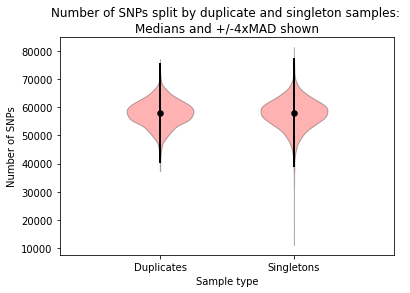

In [10]:
violin_plot('sample_qc.n_snp', 'Number of SNPs')

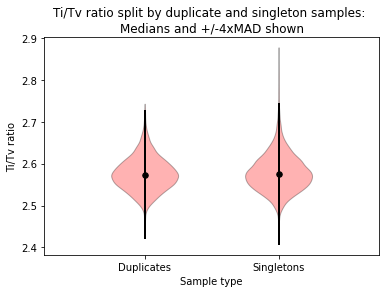

In [11]:
violin_plot('sample_qc.r_ti_tv', 'Ti/Tv ratio')

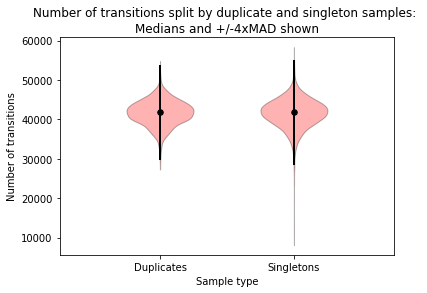

In [12]:
violin_plot('sample_qc.n_transition', 'Number of transitions')

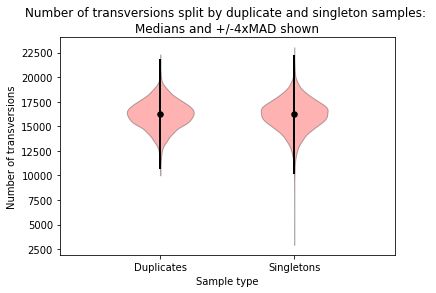

In [13]:
violin_plot('sample_qc.n_transversion', 'Number of transversions')

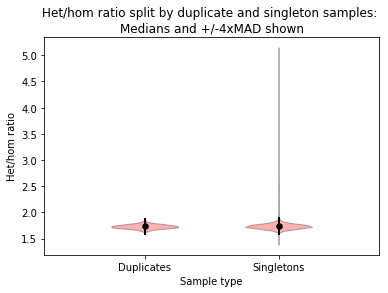

In [14]:
violin_plot('sample_qc.r_het_hom_var', 'Het/hom ratio')

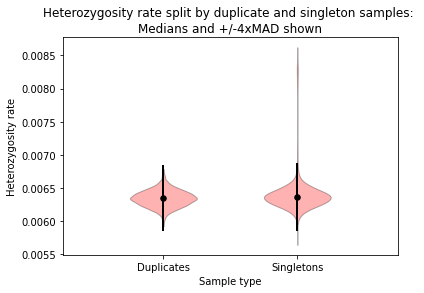

In [15]:
violin_plot('sample_qc.heterozygosity_rate', 'Heterozygosity rate')

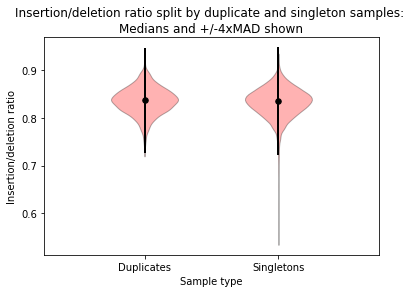

In [16]:
violin_plot('sample_qc.r_insertion_deletion', 'Insertion/deletion ratio')

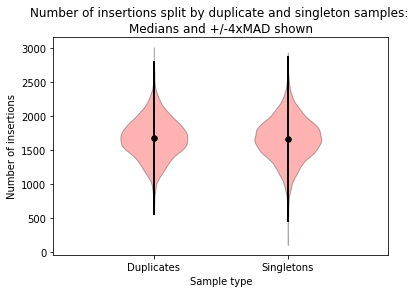

In [17]:
violin_plot('sample_qc.n_insertion', 'Number of insertions')

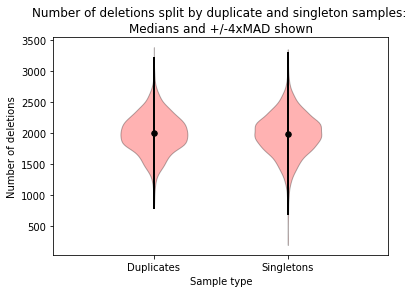

In [18]:
violin_plot('sample_qc.n_deletion', 'Number of deletions')

In [29]:
#now look at private variants - need to load matrixtables rather than just sample QC hail table. Filter variants for quality (DP, VAF, GQ), filter to confident dups and confident singletons only
mtfile = lustre_dir + "/matrixtables/non_stratified_sample_qc_dp20_gq20_vaf0_25.mt"
mt = hl.read_matrix_table(mtfile)
mt.entries().show()

+---------------+------------+------+----------+----------+--------------+
| locus         | alleles    | rsid |     qual | filters  | info.AC      |
+---------------+------------+------+----------+----------+--------------+
| locus<GRCh38> | array<str> | str  |  float64 | set<str> | array<int32> |
+---------------+------------+------+----------+----------+--------------+
| chr1:69026    | ["T","G"]  | NA   | 7.97e+01 | NA       | [1]          |
| chr1:69026    | ["T","G"]  | NA   | 7.97e+01 | NA       | [1]          |
| chr1:69026    | ["T","G"]  | NA   | 7.97e+01 | NA       | [1]          |
| chr1:69026    | ["T","G"]  | NA   | 7.97e+01 | NA       | [1]          |
| chr1:69026    | ["T","G"]  | NA   | 7.97e+01 | NA       | [1]          |
| chr1:69026    | ["T","G"]  | NA   | 7.97e+01 | NA       | [1]          |
| chr1:69063    | ["T","C"]  | NA   | 2.63e+04 | NA       | [366]        |
| chr1:69063    | ["T","C"]  | NA   | 2.63e+04 | NA       | [366]        |
| chr1:69063    | ["T","C"]  | NA   | 2.63e+04 | NA       | [366]        |
| chr1:69063    | ["T","C"]  | NA   | 2.63e+04 | NA       | [366]        |
+---------------+------------+------+----------+----------+--------------+

+----------------+---------+----------------------+----------------+
| info.AF        | info.AN | info.AS_BaseQRankSum | info.AS_FS     |
+----------------+---------+----------------------+----------------+
| array<float64> |   int32 | array<float64>       | array<float64> |
+----------------+---------+----------------------+----------------+
| [3.34e-05]     |   29946 | [-4.00e-01]          | [6.02e+00]     |
| [3.34e-05]     |   29946 | [-4.00e-01]          | [6.02e+00]     |
| [3.34e-05]     |   29946 | [-4.00e-01]          | [6.02e+00]     |
| [3.34e-05]     |   29946 | [-4.00e-01]          | [6.02e+00]     |
| [3.34e-05]     |   29946 | [-4.00e-01]          | [6.02e+00]     |
| [3.34e-05]     |   29946 | [-4.00e-01]          | [6.02e+00]     |
| [1.20e-02]     |   29946 | [0.00e+00]           | [1.21e+02]     |
| [1.20e-02]     |   29946 | [0.00e+00]           | [1.21e+02]     |
| [1.20e-02]     |   29946 | [0.00e+00]           | [1.21e+02]     |
| [1.20e-02]     |   29946 | [0.00e+00]           | [1.21e+02]     |
+----------------+---------+----------------------+----------------+

+-------------------------+----------------+-------------------+
| info.AS_InbreedingCoeff | info.AS_MQ     | info.AS_MQRankSum |
+-------------------------+----------------+-------------------+
| array<float64>          | array<float64> | array<float64>    |
+-------------------------+----------------+-------------------+
| [3.91e-01]              | [2.50e+01]     | [0.00e+00]        |
| [3.91e-01]              | [2.50e+01]     | [0.00e+00]        |
| [3.91e-01]              | [2.50e+01]     | [0.00e+00]        |
| [3.91e-01]              | [2.50e+01]     | [0.00e+00]        |
| [3.91e-01]              | [2.50e+01]     | [0.00e+00]        |
| [3.91e-01]              | [2.50e+01]     | [0.00e+00]        |
| [3.78e-01]              | [2.51e+01]     | [-3.00e-01]       |
| [3.78e-01]              | [2.51e+01]     | [-3.00e-01]       |
| [3.78e-01]              | [2.51e+01]     | [-3.00e-01]       |
| [3.78e-01]              | [2.51e+01]     | [-3.00e-01]       |
+-------------------------+----------------+-------------------+

+----------------+--------------------------+----------------+
| info.AS_QD     | info.AS_RAW_BaseQRankSum | info.AS_RAW_MQ |
+----------------+--------------------------+----------------+
| array<float64> | str                      | str            |
+----------------+--------------------------+----------------+
| [2.00e+01]     | NA                       | NA             |
| [2.00e+01]     | NA                       | NA             |
| [2.00e+01]     | NA                       | NA             |
| [2.00e+01]     | NA                       | NA             |
| [2.00e+01]     | NA                       | NA             |
| [2.00e+01]     | NA  

In [30]:
seq_expr = (hl.case()
            .when(mt.s.startswith('EGAN'), 'Sanger')
            .when(mt.s.startswith('Z'), 'Broad')
            .default("")
            )
mt = mt.annotate_cols(sequencing_location=seq_expr).key_cols_by('s')
mt = mt.filter_cols(mt.sequencing_location == 'Sanger')
mt.count()

(8352477, 11891)

In [31]:
#mt for samples which are part of duplicates
duplicate_mt = mt.filter_cols(hl.is_defined(duplicate_samples[mt.s]))
duplicate_mt.count()

(8352477, 2543)

In [32]:
duplicate_mt.entries().show()

+---------------+------------+------+----------+----------+--------------+
| locus         | alleles    | rsid |     qual | filters  | info.AC      |
+---------------+------------+------+----------+----------+--------------+
| locus<GRCh38> | array<str> | str  |  float64 | set<str> | array<int32> |
+---------------+------------+------+----------+----------+--------------+
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
+---------------+------------+------+----------+----------+--------------+

+----------------+---------+----------------------+----------------+
| info.AF        | info.AN | info.AS_BaseQRankSum | info.AS_FS     |
+----------------+---------+----------------------+----------------+
| array<float64> |   int32 | array<float64>       | array<float64> |
+----------------+---------+----------------------+----------------+
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
+----------------+---------+----------------------+----------------+

+-------------------------+----------------+-------------------+
| info.AS_InbreedingCoeff | info.AS_MQ     | info.AS_MQRankSum |
+-------------------------+----------------+-------------------+
| array<float64>          | array<float64> | array<float64>    |
+-------------------------+----------------+-------------------+
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
+-------------------------+----------------+-------------------+

+----------------+--------------------------+----------------+
| info.AS_QD     | info.AS_RAW_BaseQRankSum | info.AS_RAW_MQ |
+----------------+--------------------------+----------------+
| array<float64> | str                      | str            |
+----------------+--------------------------+----------------+
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA  

In [33]:
#remove all home ref entries - not sure if this actually does anything
duplicate_mt = duplicate_mt.filter_entries(duplicate_mt.GT.is_hom_ref(), keep = False)
duplicate_mt.count()

(8352477, 2543)

In [35]:
#mt for samples which are singletons
singleton_mt = mt.filter_cols(hl.is_defined(poss_duplicate_samples[mt.s]), keep = False)
singleton_mt.count()

(8352477, 9176)

In [36]:
#remove all home ref entries - not sure if this actually does anything
singleton_mt = singleton_mt.filter_entries(singleton_mt.GT.is_hom_ref(), keep = False)
singleton_mt.count()

(8352477, 9176)

In [37]:
singleton_mt.entries().show()

+---------------+------------+---------------+----------+----------+
| locus         | alleles    | rsid          |     qual | filters  |
+---------------+------------+---------------+----------+----------+
| locus<GRCh38> | array<str> | str           |  float64 | set<str> |
+---------------+------------+---------------+----------+----------+
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
+---------------+------------+---------------+----------+----------+

+--------------+----------------+---------+----------------------+
| info.AC      | info.AF        | info.AN | info.AS_BaseQRankSum |
+--------------+----------------+---------+----------------------+
| array<int32> | array<float64> |   int32 | array<float64>       |
+--------------+----------------+---------+----------------------+
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
+--------------+----------------+---------+----------------------+

+----------------+-------------------------+----------------+
| info.AS_FS     | info.AS_InbreedingCoeff | info.AS_MQ     |
+----------------+-------------------------+----------------+
| array<float64> | array<float64>          | array<float64> |
+----------------+-------------------------+----------------+
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
+----------------+-------------------------+----------------+

+-------------------+----------------+--------------------------+
| info.AS_MQRankSum | info.AS_QD     | info.AS_RAW_BaseQRankSum |
+-------------------+----------------+--------------------------+
| array<float64>    | array<float64> | str                      |
+-------------------+----------------+--------------------------+
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     

In [38]:
duplicate_mt = hl.variant_qc(duplicate_mt)
duplicate_mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'batch': str
    'sequencing_location': str
    'assigned_pop': str
    'sample_qc': struct {
        dp_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        gq_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: int64, 
        n_star: int64, 
        r_ti_tv: float64, 
        r_het_hom_var: float64, 


In [39]:
duplicate_mt.entries().show()

+---------------+------------+---------------+----------+----------+
| locus         | alleles    | rsid          |     qual | filters  |
+---------------+------------+---------------+----------+----------+
| locus<GRCh38> | array<str> | str           |  float64 | set<str> |
+---------------+------------+---------------+----------+----------+
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
| chr1:69428    | ["T","G"]  | "rs140739101" | 1.88e+05 | NA       |
+---------------+------------+---------------+----------+----------+

+--------------+----------------+---------+----------------------+
| info.AC      | info.AF        | info.AN | info.AS_BaseQRankSum |
+--------------+----------------+---------+----------------------+
| array<int32> | array<float64> |   int32 | array<float64>       |
+--------------+----------------+---------+----------------------+
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
| [733]        | [2.40e-02]     |   29946 | [-6.00e-01]          |
+--------------+----------------+---------+----------------------+

+----------------+-------------------------+----------------+
| info.AS_FS     | info.AS_InbreedingCoeff | info.AS_MQ     |
+----------------+-------------------------+----------------+
| array<float64> | array<float64>          | array<float64> |
+----------------+-------------------------+----------------+
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
| [1.23e+01]     | [5.93e-01]              | [3.03e+01]     |
+----------------+-------------------------+----------------+

+-------------------+----------------+--------------------------+
| info.AS_MQRankSum | info.AS_QD     | info.AS_RAW_BaseQRankSum |
+-------------------+----------------+--------------------------+
| array<float64>    | array<float64> | str                      |
+-------------------+----------------+--------------------------+
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     | NA                       |
| [-1.50e+00]       | [1.44e+01]     

In [40]:
singleton_mt = hl.variant_qc(singleton_mt)

In [42]:
singleton_mt.count_cols()

9176

In [43]:
#for a private variant n_non_ref will be 1
#n_non_ref (int64) – Number of samples with at least one called non-reference allele.
duplicate_private_vars = duplicate_mt.filter_rows(duplicate_mt.variant_qc.n_non_ref == 1)
duplicate_private_vars.count()

(579344, 2543)

In [44]:
duplicate_private_vars.entries().show()

+---------------+------------------+---------------+----------+----------+
| locus         | alleles          | rsid          |     qual | filters  |
+---------------+------------------+---------------+----------+----------+
| locus<GRCh38> | array<str>       | str           |  float64 | set<str> |
+---------------+------------------+---------------+----------+----------+
| chr1:69438    | ["T","C"]        | "rs758790416" | 2.56e+03 | NA       |
| chr1:925952   | ["G","A"]        | NA            | 2.07e+03 | NA       |
| chr1:926093   | ["A","ATCGAGAG"] | "rs772534558" | 5.34e+03 | NA       |
| chr1:930165   | ["G","A"]        | "rs201186828" | 2.66e+03 | NA       |
| chr1:930257   | ["G","A"]        | "rs769468456" | 1.26e+03 | NA       |
| chr1:930314   | ["C","T"]        | "rs9988179"   | 1.83e+04 | NA       |
| chr1:930336   | ["G","A"]        | "rs762079957" | 2.83e+03 | NA       |
| chr1:931023   | ["G","A"]        | NA            | 8.37e+02 | NA       |
| chr1:931042   | ["C","T"]        | "rs139210662" | 1.21e+04 | NA       |
| chr1:931099   | ["G","A"]        | "rs374724433" | 3.10e+03 | NA       |
+---------------+------------------+---------------+----------+----------+

+--------------+----------------+---------+----------------------+
| info.AC      | info.AF        | info.AN | info.AS_BaseQRankSum |
+--------------+----------------+---------+----------------------+
| array<int32> | array<float64> |   int32 | array<float64>       |
+--------------+----------------+---------+----------------------+
| [6]          | [2.00e-04]     |   29946 | [1.30e+00]           |
| [3]          | [1.00e-04]     |   29946 | [1.60e+00]           |
| [16]         | [5.34e-04]     |   29946 | [-5.00e-02]          |
| [4]          | [1.34e-04]     |   29946 | [-1.55e+00]          |
| [2]          | [6.68e-05]     |   29946 | [8.00e-01]           |
| [30]         | [1.00e-03]     |   29946 | [5.00e-01]           |
| [5]          | [1.67e-04]     |   29946 | [-7.00e-01]          |
| [2]          | [6.68e-05]     |   29946 | [9.00e-01]           |
| [12]         | [4.01e-04]     |   29946 | [-4.00e-01]          |
| [4]          | [1.34e-04]     |   29946 | [-3.50e-01]          |
+--------------+----------------+---------+----------------------+

+----------------+-------------------------+----------------+
| info.AS_FS     | info.AS_InbreedingCoeff | info.AS_MQ     |
+----------------+-------------------------+----------------+
| array<float64> | array<float64>          | array<float64> |
+----------------+-------------------------+----------------+
| [0.00e+00]     | [5.93e-01]              | [3.25e+01]     |
| [1.04e+00]     | [4.96e-01]              | [6.00e+01]     |
| [1.95e+00]     | [1.49e-01]              | [6.00e+01]     |
| [6.72e+00]     | [2.84e-01]              | [6.00e+01]     |
| [0.00e+00]     | [4.90e-01]              | [6.00e+01]     |
| [1.17e+00]     | [1.39e-01]              | [6.00e+01]     |
| [3.89e+00]     | [3.51e-01]              | [6.00e+01]     |
| [1.66e+00]     | [5.30e-01]              | [6.00e+01]     |
| [5.19e-01]     | [2.85e-01]              | [6.00e+01]     |
| [4.34e-01]     | [4.59e-01]              | [6.00e+01]     |
+----------------+-------------------------+----------------+

+-------------------+----------------+--------------------------+
| info.AS_MQRankSum | info.AS_QD     | info.AS_RAW_BaseQRankSum |
+-------------------+----------------+--------------------------+
| array<float64>    | array<float64> | str                      |
+-------------------+----------------+--------------------------+
| [-8.00e-01]       | [1.96e+01]     | NA                       |
| [0.00e+00]        | [1.53e+01]     | NA                       |
| [0.00e+00]        | [1.82e+01]     | NA                       |
| [0.00e+00]        | [1.63e+01]     | NA                       |
| [0.00e+00]        | [1.21e+01]     | NA                       |
| [0.00e+00]        | [1.23e+01]     | NA                       |
| [0.00

In [45]:
singleton_private_vars = singleton_mt.filter_rows(singleton_mt.variant_qc.n_non_ref == 1)
singleton_private_vars.count()

(1181490, 9176)

In [47]:
singleton_private_vars.entries().show()

+---------------+------------+---------------+----------+----------+
| locus         | alleles    | rsid          |     qual | filters  |
+---------------+------------+---------------+----------+----------+
| locus<GRCh38> | array<str> | str           |  float64 | set<str> |
+---------------+------------+---------------+----------+----------+
| chr1:69438    | ["T","C"]  | "rs758790416" | 2.56e+03 | NA       |
| chr1:69486    | ["C","T"]  | "rs548369610" | 1.05e+03 | NA       |
| chr1:69496    | ["G","A"]  | "rs150690004" | 9.18e+02 | NA       |
| chr1:69561    | ["G","T"]  | NA            | 1.12e+03 | NA       |
| chr1:69604    | ["T","C"]  | NA            | 1.14e+03 | NA       |
| chr1:925874   | ["C","G"]  | NA            | 3.79e+02 | NA       |
| chr1:925875   | ["A","G"]  | "rs561574473" | 5.74e+02 | NA       |
| chr1:925935   | ["G","A"]  | "rs200140498" | 5.49e+02 | NA       |
| chr1:925948   | ["A","C"]  | NA            | 8.92e+02 | NA       |
| chr1:925952   | ["G","A"]  | NA            | 2.07e+03 | NA       |
+---------------+------------+---------------+----------+----------+

+--------------+----------------+---------+----------------------+
| info.AC      | info.AF        | info.AN | info.AS_BaseQRankSum |
+--------------+----------------+---------+----------------------+
| array<int32> | array<float64> |   int32 | array<float64>       |
+--------------+----------------+---------+----------------------+
| [6]          | [2.00e-04]     |   29946 | [1.30e+00]           |
| [3]          | [1.00e-04]     |   29946 | [-1.45e+00]          |
| [1]          | [3.34e-05]     |   29946 | [-1.40e+00]          |
| [2]          | [6.68e-05]     |   29946 | [-1.90e+00]          |
| [2]          | [6.68e-05]     |   29946 | NA                   |
| [1]          | [3.34e-05]     |   29946 | [-1.70e+00]          |
| [1]          | [3.34e-05]     |   29946 | [-1.10e+00]          |
| [1]          | [3.34e-05]     |   29946 | [-2.50e+00]          |
| [1]          | [3.34e-05]     |   29946 | [-1.00e+00]          |
| [3]          | [1.00e-04]     |   29946 | [1.60e+00]           |
+--------------+----------------+---------+----------------------+

+----------------+-------------------------+----------------+
| info.AS_FS     | info.AS_InbreedingCoeff | info.AS_MQ     |
+----------------+-------------------------+----------------+
| array<float64> | array<float64>          | array<float64> |
+----------------+-------------------------+----------------+
| [0.00e+00]     | [5.93e-01]              | [3.25e+01]     |
| [1.92e+00]     | [5.90e-01]              | [3.49e+01]     |
| [0.00e+00]     | [5.87e-01]              | [5.34e+01]     |
| [9.01e-01]     | [5.90e-01]              | [4.43e+01]     |
| [1.46e+01]     | [5.91e-01]              | [4.81e+01]     |
| [6.79e+00]     | [1.82e-01]              | [6.00e+01]     |
| [1.54e+00]     | [2.87e-01]              | [6.00e+01]     |
| [3.27e+00]     | [5.57e-01]              | [6.00e+01]     |
| [5.92e+00]     | [5.98e-01]              | [6.00e+01]     |
| [1.04e+00]     | [4.96e-01]              | [6.00e+01]     |
+----------------+-------------------------+----------------+

+-------------------+----------------+--------------------------+
| info.AS_MQRankSum | info.AS_QD     | info.AS_RAW_BaseQRankSum |
+-------------------+----------------+--------------------------+
| array<float64>    | array<float64> | str                      |
+-------------------+----------------+--------------------------+
| [-8.00e-01]       | [1.96e+01]     | NA                       |
| [-8.50e-01]       | [1.87e+01]     | NA                       |
| [-7.00e-01]       | [1.53e+01]     | NA                       |
| [7.00e-01]        | [3.12e+01]     | NA                       |
| NA                | [3.35e+01]     | NA                       |
| [0.00e+00]        | [1.81e+01]     | NA                       |
| [0.00e+00]        | [1.47e+01]     | NA                       |
| [0.00e+00]        | [1.28e+01]     

In [51]:
#it looks like the duplicates have approx twice as many private variants per sample than the singletons: 579344 private vars in 2543 amples compared to 
#1181490 private vars in 9176 samples.
# However this isn't a fair comparison as more samples may make it more likely for a variant to be calld >1x and not be private. 
# Need to try with only a subset of the singletons so that there is the same sample count for each
# to do this, select the first 2543 rows of the singletons pands df and convert to a table
singletons_2543_df =  singleton_df.head(2543)
singletons_2543_ht = hl.Table.from_pandas(singletons_2543_df, key=['s']) 
singletons_2543_ht.count()

2543

In [52]:
singletons_2543_ht.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s,batch,sequencing_location,assigned_pop,sample_qc.dp_stats.mean,sample_qc.dp_stats.stdev,sample_qc.dp_stats.min,sample_qc.dp_stats.max,sample_qc.gq_stats.mean,sample_qc.gq_stats.stdev,sample_qc.gq_stats.min,sample_qc.gq_stats.max,sample_qc.call_rate,sample_qc.n_called,sample_qc.n_not_called,sample_qc.n_filtered,sample_qc.n_hom_ref,sample_qc.n_het,sample_qc.n_hom_var,sample_qc.n_non_ref,sample_qc.n_singleton,sample_qc.n_snp,sample_qc.n_insertion,sample_qc.n_deletion,sample_qc.n_transition,sample_qc.n_transversion,sample_qc.n_star,sample_qc.r_ti_tv,sample_qc.r_het_hom_var,sample_qc.r_insertion_deletion,sample_qc.heterozygosity_rate
str,str,str,str,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64
"""EGAN00003143328""","""38268""","""Sanger""","""EUR""",3.59e+01,1.38e+01,2.10e+01,1.32e+03,8.52e+01,1.56e+01,2.10e+01,9.90e+01,6.25e-01,5216834,0,3135643,5164536,32701,19597,52298,140,64435,2124,2510,46100,18335,2954,2.51e+00,1.67e+00,8.46e-01,6.27e-03
"""EGAN00003143329""","""38268""","""Sanger""","""EUR""",3.50e+01,1.12e+01,2.10e+01,1.04e+03,8.40e+01,1.62e+01,2.10e+01,9.90e+01,5.54e-01,4626239,0,3726238,4579527,29498,17214,46712,128,58173,1740,2005,41844,16329,2121,2.56e+00,1.71e+00,8.68e-01,6.38e-03
"""EGAN00003143330""","""38268""","""Sanger""","""AFR""",3.54e+01,1.16e+01,2.10e+01,1.30e+03,8.44e+01,1.61e+01,2.10e+01,9.90e+01,5.90e-01,4926791,0,3425686,4867203,40569,19019,59588,811,71306,2243,2632,51417,19889,2617,2.59e+00,2.13e+00,8.52e-01,8.23e-03
"""EGAN00003143331""","""38268""","""Sanger""","""EUR""",3.56e+01,1.27e+01,2.10e+01,1.01e+03,8.48e+01,1.59e+01,2.10e+01,9.90e+01,5.84e-01,4879128,0,3473349,4831331,30430,17367,47797,112,59067,1835,2134,42450,16617,2233,2.55e+00,1.75e+00,8.60e-01,6.24e-03
"""EGAN00003143334""","""38268""","""Sanger""","""EUR""",3.51e+01,1.08e+01,2.10e+01,1.01e+03,8.41e+01,1.62e+01,2.10e+01,9.90e+01,5.79e-01,4837756,0,3514721,4789458,30503,17795,48298,114,60019,1846,2148,43210,16809,2196,2.57e+00,1.71e+00,8.59e-01,6.31e-03
"""EGAN00003143337""","""38268""","""Sanger""","""EUR""",3.62e+01,1.49e+01,2.10e+01,1.53e+03,8.54e+01,1.55e+01,2.10e+01,9.90e+01,6.67e-01,5571406,0,2781071,5517317,34306,19783,54089,141,66059,2235,2635,47159,18900,3143,2.50e+00,1.73e+00,8.48e-01,6.16e-03
"""EGAN00003143338""","""38268""","""Sanger""","""EUR""",3.51e+01,1.19e+01,2.10e+01,1.10e+03,8.41e+01,1.61e+01,2.10e+01,9.90e+01,5.73e-01,4782332,0,3570145,4734717,30300,17315,47615,90,58891,1790,2083,42367,16524,2314,2.56e+00,1.75e+00,8.59e-01,6.34e-03
"""EGAN00003143340""","""38268""","""Sanger""","""EUR""",3.54e+01,1.20e+01,2.10e+01,1.16e+03,8.46e+01,1.59e+01,2.10e+01,9.90e+01,6.04e-01,5041128,0,3311349,4990804,32129,18195,50324,146,61790,1933,2330,44259,17531,2617,2.52e+00,1.77e+00,8.30e-01,6.37e-03


In [53]:
singletons_2543_mt = mt.filter_cols(hl.is_defined(singletons_2543_ht[mt.s]))
singletons_2543_mt.count() #some samples lost here - no idea why but only 7 so should be OK

(8352477, 2536)

In [54]:
singletons_2543_mt = hl.variant_qc(singletons_2543_mt)
singletons_2543_mt.entries().show()

+---------------+------------+------+----------+----------+--------------+
| locus         | alleles    | rsid |     qual | filters  | info.AC      |
+---------------+------------+------+----------+----------+--------------+
| locus<GRCh38> | array<str> | str  |  float64 | set<str> | array<int32> |
+---------------+------------+------+----------+----------+--------------+
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
| chr1:69319    | ["G","T"]  | NA   | 6.72e+01 | NA       | [7]          |
+---------------+------------+------+----------+----------+--------------+

+----------------+---------+----------------------+----------------+
| info.AF        | info.AN | info.AS_BaseQRankSum | info.AS_FS     |
+----------------+---------+----------------------+----------------+
| array<float64> |   int32 | array<float64>       | array<float64> |
+----------------+---------+----------------------+----------------+
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
| [2.34e-04]     |   29946 | [0.00e+00]           | [0.00e+00]     |
+----------------+---------+----------------------+----------------+

+-------------------------+----------------+-------------------+
| info.AS_InbreedingCoeff | info.AS_MQ     | info.AS_MQRankSum |
+-------------------------+----------------+-------------------+
| array<float64>          | array<float64> | array<float64>    |
+-------------------------+----------------+-------------------+
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
| [5.18e-01]              | [2.61e+01]     | [0.00e+00]        |
+-------------------------+----------------+-------------------+

+----------------+--------------------------+----------------+
| info.AS_QD     | info.AS_RAW_BaseQRankSum | info.AS_RAW_MQ |
+----------------+--------------------------+----------------+
| array<float64> | str                      | str            |
+----------------+--------------------------+----------------+
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA                       | NA             |
| [9.70e-01]     | NA  

In [55]:
singletons_2543_mt_private_vars = singletons_2543_mt.filter_rows(singletons_2543_mt.variant_qc.n_non_ref == 1)
singletons_2543_mt_private_vars.count()

(681841, 2536)